# Road Following - Live demo

In this notebook, we will use model we trained to move jetBot smoothly on track.

### Load Trained Model

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np

In [6]:
# Initialize the model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 1)

# Load the trained model from the checkpoint file and map it to the CPU
checkpoint = torch.load('checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## set test dataset

In [7]:
!unzip training_data2.zip
!mv training_data2 test_dataset

Archive:  training_data2.zip
   creating: training_data2/
  inflating: __MACOSX/._training_data2  
  inflating: training_data2/2-172.jpg  
  inflating: __MACOSX/training_data2/._2-172.jpg  
  inflating: training_data2/38-320.jpg  
  inflating: __MACOSX/training_data2/._38-320.jpg  
  inflating: training_data2/40-343.jpg  
  inflating: __MACOSX/training_data2/._40-343.jpg  
  inflating: training_data2/48-557.jpg  
  inflating: __MACOSX/training_data2/._48-557.jpg  
  inflating: training_data2/11-614.jpg  
  inflating: __MACOSX/training_data2/._11-614.jpg  
  inflating: training_data2/23-226.jpg  
  inflating: __MACOSX/training_data2/._23-226.jpg  
  inflating: training_data2/7-156.jpg  
  inflating: __MACOSX/training_data2/._7-156.jpg  
  inflating: training_data2/63-205.jpg  
  inflating: __MACOSX/training_data2/._63-205.jpg  
  inflating: training_data2/19-203.jpg  
  inflating: __MACOSX/training_data2/._19-203.jpg  
  inflating: training_data2/24-461.jpg  
  inflating: __MACOSX/train

Sample 1 - Image Shape: torch.Size([3, 224, 224]), x: -2.4000000953674316
Sample 2 - Image Shape: torch.Size([3, 224, 224]), x: 0.4000000059604645
Sample 3 - Image Shape: torch.Size([3, 224, 224]), x: 2.4166667461395264
Sample 4 - Image Shape: torch.Size([3, 224, 224]), x: 0.75
Sample 5 - Image Shape: torch.Size([3, 224, 224]), x: -1.5833333730697632


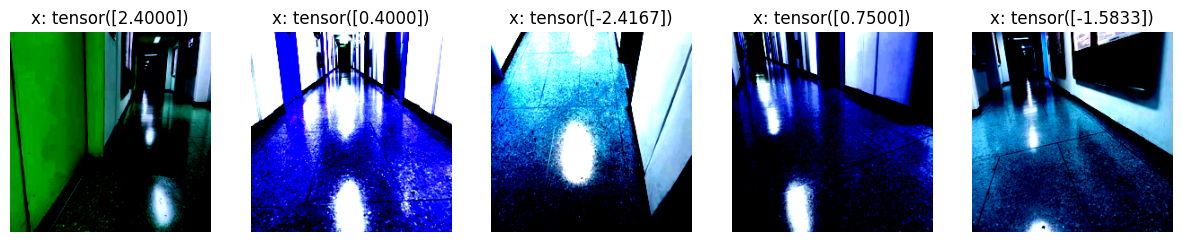

In [24]:
def get_x(file_name):
    """Gets the x value from the image filename"""
    token = file_name.split("-")
    #print(token[0], token[1])
    return (float(int(token[1].split(".")[0]) - 300.0) * 5 / 300.0)

class testDataset(torch.utils.data.Dataset):

    def __init__(self, directory):
        self.directory = directory
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        x = float(get_x(os.path.basename(image_path)))

        if float(np.random.rand(1)) > 0.5:
            image = transforms.functional.hflip(image)
            x = -x

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x]).float()

test_dataset = testDataset('test_dataset')

for i in range(5):
    image, x = test_dataset[i]
    print(f"Sample {i+1} - Image Shape: {image.shape}, x: {x.item()}")

# Visualize selected images with their predicted x values
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image, x = test_dataset[i]
    image = image.permute(1, 2, 0).numpy()

    axes[i].imshow(image)
    axes[i].set_title(f'x: {x}')
    axes[i].axis('off')

plt.show()


In [25]:
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

## evaluate

Batch [1/13] - Test Loss: 5.9109
Batch [2/13] - Test Loss: 5.8187
Batch [3/13] - Test Loss: 4.4353
Batch [4/13] - Test Loss: 5.5901
Batch [5/13] - Test Loss: 7.6573
Batch [6/13] - Test Loss: 3.9972
Batch [7/13] - Test Loss: 5.3251
Batch [8/13] - Test Loss: 6.8198
Batch [9/13] - Test Loss: 2.0699
Batch [10/13] - Test Loss: 3.1123
Batch [11/13] - Test Loss: 5.3680
Batch [12/13] - Test Loss: 4.5162
Batch [13/13] - Test Loss: 3.6968
Test Loss: 4.9475


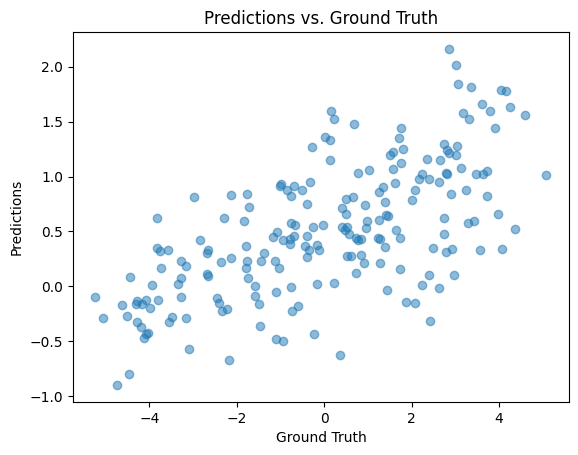

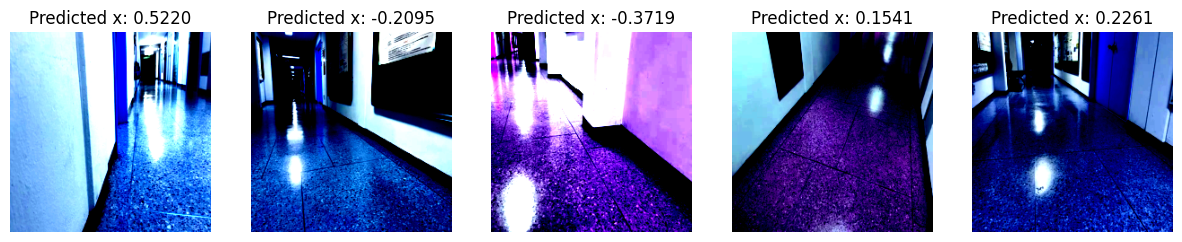

In [26]:
import matplotlib.pyplot as plt

# Ensure matplotlib is installed: pip install matplotlib

# Set the model to evaluation mode
model.eval()

# Initialize counters for debugging
total_test_batches = len(test_loader)
test_batch_count = 0
test_loss = 0.0

# Lists to store predictions and ground truth
all_predictions = []
all_labels = []

# Lists to store images and predicted x values for visualization
selected_images = []
predicted_x_values = []

# Evaluate the model on the test data
with torch.no_grad():
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)

        # Store predictions and ground truth
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store a subset of images and their predicted x values for visualization
        if len(selected_images) < 5:
            selected_images.extend(images.cpu())
            predicted_x_values.extend(outputs.cpu().numpy()[:, 0])

        # Print detailed testing information for each batch
        test_batch_count += 1
        print(f"Batch [{test_batch_count}/{total_test_batches}] - Test Loss: {loss:.4f}")

test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

# Visualize predictions vs. ground truth
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Predictions vs. Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

# Visualize selected images with their predicted x values
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image = selected_images[i].permute(1, 2, 0).numpy()
    predicted_x = predicted_x_values[i]

    axes[i].imshow(image)
    axes[i].set_title(f'Predicted x: {predicted_x:.4f}')
    axes[i].axis('off')

plt.show()


### Creating the Pre-Processing Function

In [ ]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import PIL.Image
import numpy as np

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().half()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda().half()

def preprocess(image):
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device).half()
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def ob_preprocess(image):
    image = np.array(image)
    image = torch.from_numpy(image).to(device)
    #image = transforms.functional.to_tensor(image).to(device)
    image = image.half() if ob_model.fp16 else image.float()  # uint8 to fp16/32
    image /= 255
    image = image.permute(2, 0, 1)
    transform = transforms.Resize((640, 640))
    image = transform(image)
    if len(image.shape) == 3:
        image = image[None]
    return image

### Camera Setting

In [ ]:
from IPython.display import display
import ipywidgets
import traitlets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera()

image_widget = ipywidgets.Image()

traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)

display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [ ]:
from jetbot import Robot
robot = Robot()

### Execution

In [ ]:
import time
angle = 0.0
angle_last = 0.0

def execute(change):
    global angle, angle_last
    image = change['new']
    xy = model(preprocess(image)).detach().float().cpu().numpy().flatten()
    x = xy[0]
    y = (0.5 - xy[1]) / 2.0

    speed_offset = 0.34 # 기본 speed

    angle_diff_bias = 0.1
    angle = np.arctan2(x, y) # 핸들링 angle
    if abs(angle) + angle_diff_bias < abs(angle_last): # 이전 angle보다 현재 angle이 더 작을경우
        angle_temp = -1 * angle * 0.3
    else: #
        angle_temp = angle #이전 angle 보다 현재 angle이 더 클 경우
    speed_value = speed_offset - abs(angle_temp) * 0.05 # 방향전환 상황에서는 속도를 낮춤

    if abs(angle_temp) < 0.05:
        angle_temp = 0

    angle_last = angle

    angle_temp *= 1.4 # 핸들링 배율

    # Yolo v5
    pred = ob_model(ob_preprocess(image), augment=False)

    # NMS
    pred = non_max_suppression(pred, conf_thres = 0.25, iou_thres = 0.45, classes = None, agnostic = False, max_det=1000)

    pred = pred[0] # => pred : bounding box 좌표(x1, y1, x2, y2), confidence score, class => total 6개의 값으로 나타남.

    bbox_threshold = 0 # 설정해야할 값(bbox가 얼마나 클 때 장애물로 인식할 것인지?)

    bbox_count = 0
    for *box, cf, cls in pred:
        cf = cf.item()
        cls = cls.item()

        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))

        bbox_area = (p2[0] - p1[0]) * (p2[1] - p1[1])
        if bbox_area > bbox_threshold:
            bbox_count = 1
#     print("object : {}, left_motor : {}, right_motor : {}".format(bbox_count, robot.left_motor.value, robot.right_motor.value))

    if bbox_count > 0:
      robot.left_motor.value = 0.0
      robot.right_motor.value = angle_temp
    else:
      robot.left_motor.value = speed_value
      robot.right_motor.value = angle_temp


execute({'new': camera.value})
camera.observe(execute, names='value')

object : 0, left_motor : 0.0, right_motor : -2.0129894801993284
object : 0, left_motor : 0.2661047968419968, right_motor : 2.06906568842409
object : 0, left_motor : 0.2675059203051101, right_motor : 2.0298342314569164
object : 0, left_motor : 0.26732979150241387, right_motor : 2.034765837932411
object : 0, left_motor : 0.2684392958564491, right_motor : 2.0036997160194248
object : 0, left_motor : 0.266956829541244, right_motor : 2.0452087728451684
object : 0, left_motor : 0.26660482755243636, right_motor : 2.0550648285317825
object : 0, left_motor : 0.2669751684236802, right_motor : 2.0446952841369552
object : 0, left_motor : 0.26551630326530024, right_motor : 2.0855435085715937
object : 0, left_motor : 0.2668539823602303, right_motor : 2.048088493913553
object : 0, left_motor : 0.26660916880463875, right_motor : 2.054943273470115
object : 0, left_motor : 0.26707373319113253, right_motor : 2.0419354706482893
object : 0, left_motor : 0.26548745657344086, right_motor : 2.0863512159436564


### Execution STOP

In [ ]:
import time

camera.unobserve(execute, names='value')

time.sleep(0.1)  # add a small sleep to make sure frames have finished processing

robot.stop()

object : 0, left_motor : 0.2684451044387417, right_motor : 2.0035370757152338
object : 0, left_motor : 0.0, right_motor : 0.0


######